scanpy==1.10.3 anndata==0.10.9 umap==0.5.6 numpy==1.23.5 scipy==1.11.4 pandas==2.2.3 scikit-learn==1.5.2 statsmodels==0.14.4 igraph==0.10.8 louvain==0.8.0 pynndescent==0.5.13
成功加载文件: D:/111/scatac.h5ad

--- AnnData 对象概览 ---
AnnData object with n_obs × n_vars = 80299 × 12685
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'species', 'louvain', 'anno'
    var: 'n_cells_by_counts', 'total_counts', 'mean_counts', 'pct_dropout_by_counts', 'log1p_total_counts', 'log1p_mean_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'anno_colors', 'hvg', 'log1p', 'louvain', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    obsp: 'connectivities', 'distances'

--- 细胞元数据 (adata.obs) ---
前5行:
                                     sample  n_genes_by_counts  total_counts  \
AAACAAGCAACCTCGC-1  S_6M_AG-multi_atac.h5ad                754        1076.0 

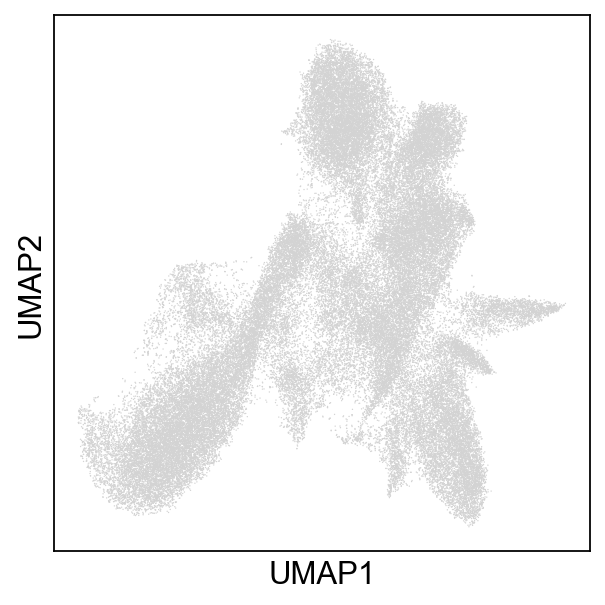


没有有效的特征名可供 UMAP 着色。请检查 `feature_names_to_plot` 列表和你的 `adata.var_names`。

--- 探索完成 ---


In [1]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. 设置参数 ---
# 设置 Scanpy 的绘图参数 (可选，让图形更美观)
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

# --- 2. 加载 h5ad 文件 ---
# !!! 修改为你 h5ad 文件的实际路径 !!!
h5ad_file_path = 'D:/111/scatac.h5ad'
try:
    adata = sc.read_h5ad(h5ad_file_path)
    print(f"成功加载文件: {h5ad_file_path}")
except FileNotFoundError:
    print(f"错误：找不到文件 {h5ad_file_path}，请检查路径是否正确。")
    exit()
except Exception as e:
    print(f"加载文件时发生错误: {e}")
    exit()

# --- 3. 探索 AnnData 对象的基本信息 ---
print("\n--- AnnData 对象概览 ---")
print(adata)

print("\n--- 细胞元数据 (adata.obs) ---")
print("前5行:")
print(adata.obs.head())
print("\n所有列名:")
print(adata.obs.columns.tolist())
# 查看某一列的唯一值 (例如，查看聚类标签有哪些)
# !!! 修改 'leiden' 为你实际存储聚类标签的列名 !!!
cluster_column = 'louvain' # 或者 'clusters', 'cell_type' 等，根据你的文件确定
if cluster_column in adata.obs.columns:
    print(f"\n'{cluster_column}' 列的唯一值:")
    print(adata.obs[cluster_column].astype('category').cat.categories.tolist())
    print(f"\n'{cluster_column}' 列的值分布:")
    print(adata.obs[cluster_column].value_counts())
else:
    print(f"\n警告: 在 adata.obs 中未找到列 '{cluster_column}'。请检查你的列名。")


print("\n--- 特征元数据 (adata.var) ---")
print("前5行:")
print(adata.var.head())
print("\n所有列名:")
print(adata.var.columns.tolist())
print(f"\n总特征数 (peaks/bins): {adata.n_vars}")

print("\n--- 降维嵌入信息 (adata.obsm) ---")
print("可用的嵌入:")
print(list(adata.obsm.keys()))

print("\n--- 其他非结构化信息 (adata.uns) ---")
print("可用的键:")
print(list(adata.uns.keys()))
# 例如，查看聚类的颜色映射 (如果存在)
if cluster_column in adata.obs.columns and f'{cluster_column}_colors' in adata.uns:
     print(f"\n'{cluster_column}' 的颜色映射:")
     print(adata.uns[f'{cluster_column}_colors'])


# --- 4. 可视化 ---
# 检查 UMAP 结果是否存在
umap_key = 'X_umap' # Scanpy 默认的 UMAP 存储键
if umap_key not in adata.obsm:
    print(f"\n警告: 在 adata.obsm 中未找到 '{umap_key}'。无法绘制 UMAP 图。")
    # 你可以检查其他的 obsm 键，比如 'X_tsne' 等
    available_embeddings = list(adata.obsm.keys())
    if available_embeddings:
        print(f"可用的嵌入有: {available_embeddings}。请修改脚本以使用其中一个。")
    else:
        print("没有找到可用的降维嵌入信息。")
else:
    print(f"\n--- 绘制 UMAP 图 ({umap_key}) ---")

    # --- a) 根据细胞元数据列进行着色 ---
    # !!! 修改 color 列表中的列名为你 adata.obs 中实际存在的列 !!!
    # 常见的列名可能有: 'leiden', 'louvain', 'cell_type', 'sample', 'n_counts_atac', 'log1p_n_counts_atac' 等
    columns_to_plot = []
    if cluster_column in adata.obs.columns:
        columns_to_plot.append(cluster_column)
    # 添加其他你感兴趣的 obs 列名
    # 例如: columns_to_plot.extend(['cell_type', 'sample', 'log1p_n_counts_atac'])

    # 过滤掉不存在的列，避免报错
    valid_columns_to_plot = [col for col in columns_to_plot if col in adata.obs.columns]
    invalid_columns = [col for col in columns_to_plot if col not in adata.obs.columns]
    if invalid_columns:
        print(f"\n警告: 以下列名在 adata.obs 中不存在，无法用于绘图: {invalid_columns}")
        print(f"可用的 adata.obs 列名: {adata.obs.columns.tolist()}")

    if valid_columns_to_plot:
        print(f"\n绘制 UMAP，根据以下元数据着色: {valid_columns_to_plot}")
        sc.pl.umap(adata, color=v['sample', 'species', 'louvain', 'anno'], title=[f'UMAP colored by {col}' for col in valid_columns_to_plot], show=False)
        plt.tight_layout() # 调整布局防止重叠
        plt.show() # 显示图形
    else:
        print("\n没有有效的列可供 UMAP 着色。请检查 `columns_to_plot` 列表和你的 `adata.obs`。")
        # 可以只绘制没有颜色的 UMAP
        print("\n绘制无着色的 UMAP")
        sc.pl.umap(adata, show=False)
        plt.tight_layout()
        plt.show()

    # --- b) 根据特定特征 (Peak/Bin/Gene) 的可及性进行着色 ---
    # !!! 修改 feature_names 列表为你 adata.var_names 中实际存在的特征名 !!!
    # 注意：这里的特征名取决于你的 h5ad 文件是如何构建的。
    # 它可能是 peak 坐标 (e.g., 'chr1-10000-10500') 或基因名 (如果进行了 Gene Activity Score 计算)
    feature_names_to_plot = []
    # 例如: feature_names_to_plot = ['chr1-12345-12845', 'CD4', 'GATA3'] # 假设 CD4/GATA3 是 Gene Activity Score

    # 检查特征名是否存在
    valid_feature_names = [name for name in feature_names_to_plot if name in adata.var_names]
    invalid_feature_names = [name for name in feature_names_to_plot if name not in adata.var_names]

    if invalid_feature_names:
        print(f"\n警告: 以下特征名在 adata.var_names 中不存在，无法用于绘图: {invalid_feature_names}")
        # 可以打印一些存在的特征名作为参考
        print(f"部分存在的特征名示例: {adata.var_names[:5].tolist()}")

    if valid_feature_names:
        print(f"\n绘制 UMAP，根据以下特征的可及性着色: {valid_feature_names}")
        # use_raw=False 表示使用 adata.X 中的数据 (通常是处理过的)
        # 如果你的原始计数在 adata.raw.X，你可能需要设置 use_raw=True
        sc.pl.umap(adata, color=valid_feature_names, title=[f'Accessibility of {name}' for name in valid_feature_names], use_raw=False, cmap='viridis', show=False)
        plt.tight_layout()
        plt.show()
    else:
        print("\n没有有效的特征名可供 UMAP 着色。请检查 `feature_names_to_plot` 列表和你的 `adata.var_names`。")

print("\n--- 探索完成 ---")

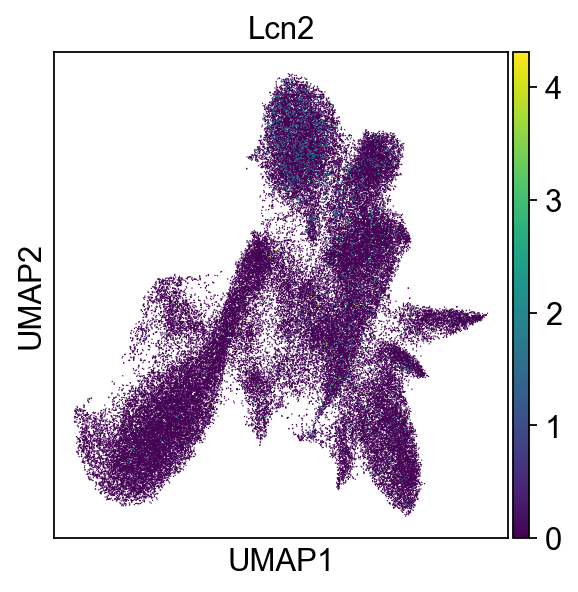

<Figure size 320x320 with 0 Axes>

In [11]:
sc.pl.umap(adata, color='Lcn2')
plt.tight_layout() # 调整布局防止重叠
plt.show() # 显示图形